In [1]:
import librosa
import librosa.display
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
from pydub import AudioSegment
%matplotlib inline
import os

In [2]:
# f_path = 'C:/Users/jmlik/Desktop/Work/mywork/simplevad/auditok_eg/jeju.wav'
f_path = 'shinmina.wav'
# f_path = 'sojoong2.wav'
wave, fs = librosa.load(f_path, sr=None)

# """
# median filtered
# """
# wave = scipy.signal.medfilt(wave)
# """
# normalization
# """
# wave = wave / np.max(np.abs(wave), axis=0)

In [3]:
def _get_frame(frame_sample_ms=20, shift_sample_ms=10):
    """
    input: frame_sample_ms(samples of window, ms단위, int)
           shift_sample_ms(samples of shift, ms단위, int)
    todo: frame과 hop_frame의 길이 안의 samples를 계산
    return: frame_len, frame_shift 
            자료형은 int
    """
    frame_len = int(frame_sample_ms*fs/1000) # frame_len = len_sample(ms) 만큼의 samples
    frame_shift = int(shift_sample_ms*fs/1000)
    return frame_len, frame_shift

def _get_rms_zcr(frame_sample_ms=20, shift_sample_ms=10):
    """
    input: frame_sample_ms, shift_sample_ms
    todo: RMS, ZCR 계산 후 벡터라이징
    return: rms, zcr
    """
    # get frame_len, frame_shift
    frame_len, frame_shift = _get_frame(frame_sample_ms, shift_sample_ms)
    # calculate RMS
    rms = librosa.feature.rmse(wave,frame_length=frame_len, hop_length=frame_shift)
    rms = rms[0]
    rms = librosa.util.normalize(rms, axis=0)
    # calculate zero-crossing rate
    zcr = librosa.feature.zero_crossing_rate(wave+0.02, frame_length=frame_len, hop_length=frame_shift)
    zcr = zcr[0]
    return rms, zcr
    
def _get_frame_idxs(min_rms=0.1, min_zcr=0.3):
    """
    rms, zcr을 구한 뒤 실행
    todo: rms와 zcr의 기준점을 인풋으로 하여 조건을 충족하는 element의 인덱스를 return.(현재는 임의)
    input: min_rms, min_zcr
    return: frame_idxs
    """
    rms, zcr = _get_rms_zcr()
    frame_idxs = np.where((rms>min_rms) | (zcr>min_zcr))[0]
    return frame_idxs

def _getboundaries(frame_idxs, frame_len, frame_shift):
    """
    todo: starttime과 endtime을 구한다.
    input: frame_idxs, frame_len,frame_shift
    return: start_t, end_t (시작시간과 끝시간을 np.array로 리턴한다.)
    """
    start_idxs = [frame_idxs[0]]
    end_idxs = []
    shapeOfIdxs = np.shape(frame_idxs)
    for i in range(shapeOfIdxs[0]-1):
        if (frame_idxs[i+1]-frame_idxs[i]) != 1:
            end_idxs.append(frame_idxs[i])
            start_idxs.append(frame_idxs[i+1])
    end_idxs.append(frame_idxs[-1])
    
    # del the last boundaries if it is both start point and end point
    if end_idxs[-1] == start_idxs[-1]:
        end_idxs.pop()
        start_idxs.pop()
    assert len(start_idxs) == len(end_idxs), "Error! Num of start_idxs doesnt match Num of end_idxs"
    start_idxs = np.array(start_idxs)
    end_idxs = np.array(end_idxs)
    start_t = start_idxs*frame_shift/fs
    end_t=end_idxs*frame_shift/fs
    return start_t, end_t

def _arraytolist(start_t, end_t):
    """
    todo: 시작, 끝, 구간시간, 구간별차이시간을 구해서 리턴한다.
    input: start_t, end_t
    output: [[start, end], 구간시간, 구간별차이시간(gap)]의 리스트
    """
    tolist = list(zip(start_t, end_t))
    info_list = []
    for i in range(len(tolist)):
        elm_minus = tolist[i][1] - tolist[i][0]
        elm_minus = round(elm_minus, 3)
        if i != 0: #이전과의 gap을측정
            gap = tolist[i][0] - tolist[i-1][1]
            gap = round(gap, 3)
        else: # i==0
            gap = -1 # 예외처리
        to_append = [[tolist[i][0], tolist[i][1]], elm_minus, gap]
        info_list.append(to_append)
    return info_list 
            
def endpoint_connect(info_list, prm_len=0.1, prm_gap=0.3):
    """
    todo: 구간길이와, 구간별 gap을 통하여 endpoint를 연결하고
          너무 짧은 구간은 삭제한다.
    input: info_list,  prm_len(구간의 길이), prm_gap(구간별 타임코드의 차이)
    return: confirm_list(모든 처리가 끝난 후의 리스트, info_list와 같은 형식)
    """
    i = 1
    tmp = 0
    new_zip = [] # 간격이 벌어진 구간이 나타날 때 이전 구간을 저장하는 곳
    confirm_list = []
    while i < len(info_list):         
        if info_list[i][2] <= prm_gap: # 간격이 작으면 앞의 것과 연결하기
            info_list[tmp][0][1] = info_list[i][0][1]
            if i == len(info_list)-1:
                new_zip.append(info_list[tmp][0])
        else: # 간격이 충분히 크다면
            new_zip.append(info_list[tmp][0])
            tmp = i # 시작 변경
        i += 1
    for elm in new_zip: # 확정구간중 너무 작은 구간을 제거함
        if elm[1]-elm[0] < prm_len:
            pass
        else:
            confirm_list.append(elm)
    return confirm_list
            

In [4]:
def audioseg(t1, t2, i=0, rms=0):
    """
    todo: t1(sec), t2(sec) 사이를 잘라 지정 디렉토리에 리턴하는 함수
    input: t1, t2
    output: 디렉토리에 파일 생성
    """
    t1 = t1*1000
    t2 = t2*1000
    newAudio = AudioSegment.from_wav(f_path)
    newAudio = newAudio[t1:t2]
    try:
        export_path = 'C:\\Users\\jmlik\\Desktop\\Work\\mywork\\simplevad\\auditok_eg\\'+str(rms)
        mkdir_mina = os.mkdir(export_path)
    except:
        export_path = 'C:\\Users\\jmlik\\Desktop\\Work\\mywork\\simplevad\\auditok_eg\\'+str(rms)
    return newAudio.export(export_path+'\\newmina' +str(i)+ '.wav', format="wav")

def makeWavFile(confirm_list, rms):
    for num in range(len(confirm_list)):
        audioseg(confirm_list[num][0], confirm_list[num][1], num, rms)
    return "Finish"

In [5]:
def get_info_list(rms_min, zcr_min):
    frame_len, frame_shift = _get_frame()
    rms, zcr = _get_rms_zcr()
    frame_idxs = _get_frame_idxs(rms_min, zcr_min)
    start_t, end_t = _getboundaries(frame_idxs, frame_len, frame_shift)
    info_list = _arraytolist(start_t, end_t)
    return info_list

def get_confirm_list(rms, zcr, prm_len, prm_gap):
    info_list = get_info_list(rms, zcr)
    confirm_list = endpoint_connect(info_list, prm_len, prm_gap)
    return confirm_list

In [6]:
def make_x_bar(gap):
    """
    rms, zcr gap으로 x_bar 만들기
    """
    x_bar = np.arange(0, 1, gap)
    return x_bar

def _get_offrate_rms(x_bar):
    """zrc고정"""
    prelen = len(_get_frame_idxs(0, 1))
    nowlen = 0
    y_bar = []
    toreturn = []
    toreturndic = {}
    for i in x_bar:
        nowlen = len(_get_frame_idxs(i, 1))
        offrate = 1 - (nowlen/prelen)
        offrate = round(offrate, 2)
        toreturndic = {"RMS":round(i,3), "Offrate":offrate}
        toreturn.append(toreturndic)
        prelen = nowlen

    return toreturn

def _get_offrate_zcr(x_bar):
    """
    rms 고정
    """    
    prelen = len(_get_frame_idxs(1, 0))
    nowlen = 0
    y_bar = []
    toreturn = []
    toreturndic = {}
    for i in x_bar:
        nowlen = len(_get_frame_idxs(1, i))
        try:
            offrate = 1 - (nowlen/prelen)
            offrate = round(offrate, 2)
            toreturndic = {"ZCR":round(i,3), "Offrate":offrate}
            toreturn.append(toreturndic)
            prelen = nowlen
        except:
            offrate = 0.0
            toreturndic = {"ZCR":round(i, 3), "Offrate":offrate}
            toreturn.append(toreturndic)

    return toreturn

def _get_doffrate_rms(rms_and_offrate_dic):
    """
    dic에 doffrate 추가하기
    """
    x_bar = []
    y_axis = []
    for i in rms_and_offrate_dic:
        x_bar.append(i["RMS"])
        y_axis.append(i["Offrate"])
    dx = x_bar[1] - x_bar[0]
    dorlist = []
    for idx, elm in enumerate(y_axis):
        if idx == 0: # 끝이라면
            dor = 0.0
            dorlist.append(dor)
        else:
            dor = (y_axis[idx] - y_axis[idx-1]) / dx
            dor = round(dor,3)
            dorlist.append(dor)                

    for idx, elm in enumerate(rms_and_offrate_dic):
        elm["dOffrate"] = dorlist[idx]

    """
    float로 바꾸기
    """
    for idx, elm in enumerate(rms_and_offrate_dic):
        elm["RMS"] = int(elm["RMS"] * 100) / 100
        elm["dOffrate"] = int(elm["dOffrate"] * 100) / 100
    
    return rms_and_offrate_dic

def _get_doffrate_zcr(zcr_and_offrate_dic):
    """
    dic에 doffrate 추가하기
    """
    x_bar = []
    y_axis = []
    for i in zcr_and_offrate_dic:
        x_bar.append(i["ZCR"])
        y_axis.append(i["Offrate"])
    dx = x_bar[1] - x_bar[0]
    dorlist = []
    for idx, elm in enumerate(y_axis):
        if idx == 0: # 끝이라면
            dor = 0.0
            dorlist.append(dor)
        else:
            dor = (y_axis[idx] - y_axis[idx-1]) / dx
            dor = round(dor,3)
            dorlist.append(dor)                

    for idx, elm in enumerate(zcr_and_offrate_dic):
        elm["dOffrate"] = dorlist[idx]

    """
    float로 바꾸기
    """
    
    for idx, elm in enumerate(zcr_and_offrate_dic):
        elm["ZCR"] = int(elm["ZCR"] * 100) / 100
        elm["dOffrate"] = int(elm["dOffrate"] * 100) / 100
    
    return zcr_and_offrate_dic

In [67]:
_get_frame_idxs(1, 0)

array([    7,     8,     9, ..., 86513, 86514, 86515], dtype=int64)

In [92]:
x_bar = make_x_bar(0.03)
# total_rms = _get_doffrate_rms(_get_offrate_rms(x_bar))
# total_rms
# total_zcr = _get_doffrate_zcr(_get_offrate_zcr(x_bar))
offrate_zcr = _get_offrate_zcr(x_bar)
offrate_zcr

[{'Offrate': 0.0, 'ZCR': 0.0},
 {'Offrate': 0.43, 'ZCR': 0.029999999999999999},
 {'Offrate': 0.7, 'ZCR': 0.059999999999999998},
 {'Offrate': 0.74, 'ZCR': 0.089999999999999997},
 {'Offrate': 0.67, 'ZCR': 0.12},
 {'Offrate': 0.62, 'ZCR': 0.14999999999999999},
 {'Offrate': 0.48, 'ZCR': 0.17999999999999999},
 {'Offrate': 0.43, 'ZCR': 0.20999999999999999},
 {'Offrate': 0.38, 'ZCR': 0.23999999999999999},
 {'Offrate': 0.24, 'ZCR': 0.27000000000000002},
 {'Offrate': 0.35, 'ZCR': 0.29999999999999999},
 {'Offrate': 0.43, 'ZCR': 0.33000000000000002},
 {'Offrate': 0.38, 'ZCR': 0.35999999999999999},
 {'Offrate': 0.0, 'ZCR': 0.39000000000000001},
 {'Offrate': 0.2, 'ZCR': 0.41999999999999998},
 {'Offrate': 0.08, 'ZCR': 0.45000000000000001},
 {'Offrate': 0.18, 'ZCR': 0.47999999999999998},
 {'Offrate': 0.44, 'ZCR': 0.51000000000000001},
 {'Offrate': 1.0, 'ZCR': 0.54000000000000004},
 {'Offrate': 0.0, 'ZCR': 0.56999999999999995},
 {'Offrate': 0.0, 'ZCR': 0.59999999999999998},
 {'Offrate': 0.0, 'ZCR': 0.

In [7]:
def pick_rms(gap):
    x = make_x_bar(gap)
    AboutRMS = _get_doffrate_rms(_get_offrate_rms(x))
    totalAboutRMS = []
    for i in AboutRMS:
        if i["dOffrate"] < 0:
            pass
        else:
            totalAboutRMS.append(i)
    """
    dic to list
    """
    offrate_list = []
    doffrate_list = []
    for i in totalAboutRMS:
        offrate_list.append(i["Offrate"])
        doffrate_list.append(i["dOffrate"])
    """
    list to array
    """
    offrate_array = np.asarray(offrate_list)
    doffrate_array = np.asarray(doffrate_list)
    
    """
    mean, std 구하기
    """
    offrate_mean = np.mean(offrate_array)
    offrate_std = np.std(offrate_array)
    doffrate_mean = np.mean(offrate_array)
    
    mul_standard = (offrate_mean + offrate_std) * doffrate_mean
    
    for idx,i in enumerate(totalAboutRMS):
        if ((i["Offrate"] + offrate_std) * i["dOffrate"] > mul_standard
           and i["Offrate"] > offrate_mean
           and i["dOffrate"] > doffrate_mean) :
            standard_rms = i["RMS"]
            break
        else:
            pass
    
    return standard_rms

def pick_zcr(gap):
    x = make_x_bar(gap)
    AboutZCR = _get_doffrate_zcr(_get_offrate_zcr(x))
    totalAboutZCR = []
    for i in AboutZCR:
        if i["dOffrate"] < 0:
            pass
        else:
            totalAboutZCR.append(i)
    """
    dic to list
    """
    offrate_list = []
    doffrate_list = []
    for i in totalAboutZCR:
        offrate_list.append(i["Offrate"])
        doffrate_list.append(i["dOffrate"])
    """
    list to array
    """
    offrate_array = np.asarray(offrate_list)
    doffrate_array = np.asarray(doffrate_list)
    
    """
    mean, std 구하기
    """
    offrate_mean = np.mean(offrate_array)
    offrate_std = np.std(offrate_array)
    doffrate_mean = np.mean(offrate_array)
    
    mul_standard = (offrate_mean + offrate_std) * doffrate_mean
    
    for idx,i in enumerate(totalAboutZCR):
        if ((i["Offrate"] + offrate_std) * i["dOffrate"] > mul_standard
           and i["Offrate"] > offrate_mean
           and i["dOffrate"] > doffrate_mean) :
            standard_zcr = i["ZCR"]
            break
        else:
            pass
    
    return standard_zcr

In [8]:
rms = pick_rms(0.015)
zcr = pick_zcr(0.015)
rms, zcr

(0.04, 0.01)

In [290]:
confirm_list = get_confirm_list(rms, zcr, 0.001, 0.02)
"""
오디오파일 생성
"""
makeWavFile(confirm_list, rms=rms)

'Finish'

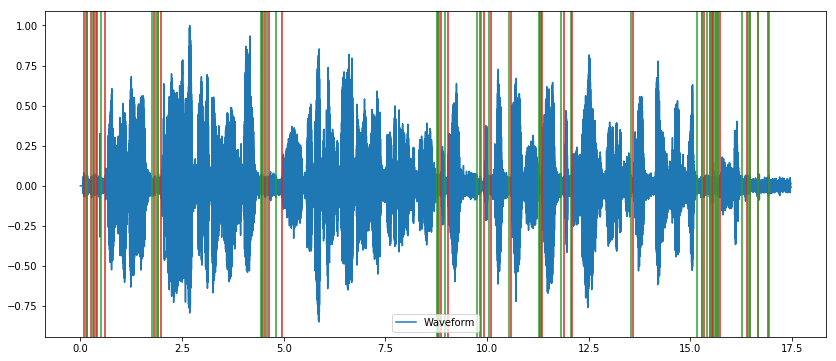

In [291]:
plt.figure(figsize=(14,6))
t = np.linspace(0, len(wave)/fs, len(wave))
plt.plot(t, wave, label='Waveform')
for i in confirm_list:
    plt.axvline(x=i[0], color="#d62728")
    plt.axvline(x=i[1], color="#2ca02c")
plt.legend(loc='best')
plt.show()

In [9]:
import scipy

In [16]:
a = np.asanyarray(wave)
m = a.mean(axis=0)
sd = a.std(axis=0, ddof=0)
np.where(sd==0, 0, m/sd)

array(5.809805224998854e-05)